# **Decision Trees - rice_ml**
This notebook demonstrates how to use the DecisionTreeClassifier class within the rice_ml package. It demonstrates them in an informative way that also analyzes the results, mirroring a standard use case of the classes. To learn about the DecisionTreeRegressor class, look at the Regression_Trees.ipynb folder.

Note that when using this in robust model selection, k-fold cross-validation and deeper hyperparameter tuning is recommended. In this example, since it's main goal is demonstrating the classes, we will not do as deep of hyperparameter tuning, and will compare every test using the same random state (42).

This notebook shows how to:
- Use 'DecisionTreeClassifier' from 'rice_ml'
- Prepare and normalize data using 'rice_ml'
- Evaluate decision trees on a classification task

## Table of Contents
- [Algorithm](#algorithm)
- [Data Preparation](#data-preparation)
- [Decision Tree Classification](#decision-tree-classification)
  - [Model Training](#model-training)
  - [Results](#results)

## Algorithm
A decision tree classifier is a supervised learning algorithm that models a categorical outcome by recursively dividing the feature space into regions and assigning a class label to each region. Unlike regression trees, which predict continuous values, classification trees predict discrete class labels.

The algorithm repeatedly selects a feature and a value to split the data in a way that best separates the classes. Instead of minimizing mean squared error, classification trees use impurity measures such as Gini impurity or entropy to evaluate splits. At each node in the tree, the algorithm chooses the split that results in the greatest reduction in impurity, continuing down the tree until a leaf node is reached. Each internal node represents a decision rule, and each leaf node represents a predicted class (often the majority class of the samples in that leaf).

To make a prediction, a data point is passed through the tree, following the decision rules at each node until it reaches a leaf. The class label associated with that leaf is then returned as the prediction.

Decision tree classifiers are effective at modeling nonlinear decision boundaries and feature interactions without requiring feature transformations. However, they rely heavily on the quality of the splits chosen during training and can easily overfit the data if the tree is allowed to grow too deep.

A common way to reduce overfitting is to limit the depth of the tree or to use ensemble methods such as random forests, which combine predictions from many trees. A single decision tree often serves as a strong and interpretable baseline for more powerful ensemble classifiers.

![Decision Tree Example](../images/decision_tree_example.jpg)
Source: [Normalized Nerd (Youtube)](https://www.youtube.com/watch?v=ZVR2Way4nwQ)


### Pros vs Cons
#### Pros
- Interpretable and easy to visualize
- Handles nonlinear relationships very well
- Works with mixed feature types (numerical and categorical can be handled directly)
- Fast predictions
#### Cons
- Can easily overfit
- High variance
- Constant predictions within each leaf (can cause sharp and unrealistic jumps in output if there are not enough leafs)
- Can't handle high-dimensional data efficiently.

## Data Preparation
We will be using the MNIST digits dataset. It is a widely used benchmark for image classification. It contains 70,000 grayscale images of handwritten digits (0-9). Each image is 28x28 pixels.
For sake of runtime, we will be using a random 10,000 data point sample from the dataset.

X shape: (10000, 784)
y shape: (10000,)
X Overall Summary:
Min: 0.000
Max: 1.000
Mean: 0.132
Std: 0.309
Before normalization:
Mean (first 5 features): [0. 0. 0. 0. 0.]
Std  (first 5 features): [0. 0. 0. 0. 0.]
Min  (first 5 features): [0. 0. 0. 0. 0.]
Max  (first 5 features): [0. 0. 0. 0. 0.]


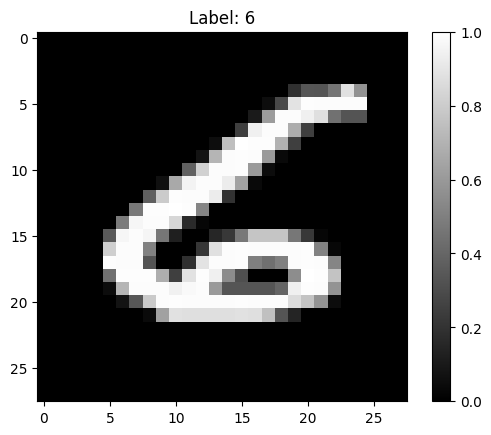

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from rice_ml.utilities import normalize, train_test_split

np.random.seed(42)

X_raw, y_raw = fetch_openml(
    "mnist_784",
    version=1,
    return_X_y=True,
    as_frame=False
)

## MNIST is a massive digits dataset, so we are taking a random sample of it.
rng = np.random.default_rng(42)
idxs = np.arange(len(X_raw))
rng.shuffle(idxs)

idxs = idxs[:10000]

X_raw = X_raw[idxs]
y_raw = y_raw[idxs]

X = np.asarray(X_raw)
y = np.asarray(y_raw)

# Scaling
X = X / 255.0
y = y.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

print("X Overall Summary:")
print(f"Min: {X.min():.3f}")
print(f"Max: {X.max():.3f}")
print(f"Mean: {X.mean():.3f}")
print(f"Std: {X.std():.3f}")

print("Before normalization:")
print("Mean (first 5 features):", np.round(X.mean(axis=0)[:5], 2))
print("Std  (first 5 features):", np.round(X.std(axis=0)[:5], 2))
print("Min  (first 5 features):", X.min(axis=0)[:5])
print("Max  (first 5 features):", X.max(axis=0)[:5])

image = X[0].reshape(28, 28)

plt.imshow(image, cmap="gray")
plt.title(f"Label: {y[0]}")
plt.colorbar()
plt.show()

## Decision Tree Classification

### Model Training
Decision trees can be very costly for high-dimensional data such as the digits data we are using, so we are going to apply PCA before running the model.

In [2]:
from rice_ml.unsupervised_learning.pca import PrincipalComponentAnalysis

X = np.asarray(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

pca = PrincipalComponentAnalysis(n_components=30)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

KNN Classification Accuracy: 0.333


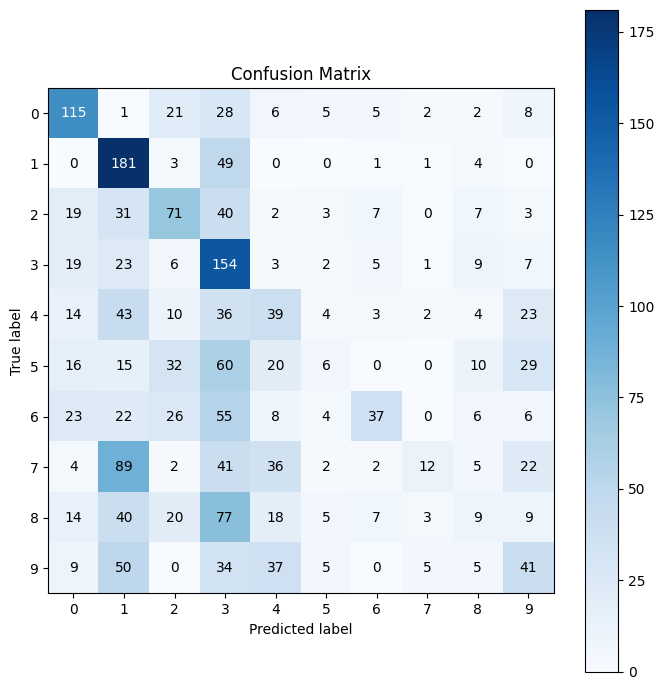

In [ ]:
from rice_ml.supervised_learning.decision_trees import DecisionTreeClassifier
from rice_ml.utilities.preprocess import train_test_split
from rice_ml.utilities.results import *

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=5
)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)

print(f"Decision Tree Accuracy: {accuracy:.3f}")
cm = confusion_matrix(y_test, results, num_classes=10)
plot_confusion_matrix(cm, class_labels=list(range(10)))

We can see that these results are very poor. With the number of classes we have, using just one decision tree can be difficult if the tree isn't deep enough. Hyperparameter tuning is crucial for this model.

We will look at some different max_depths and compare them to quickly highlight how much of a difference they make.

#### Effect of max_depth on Model Performance

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

nn = [1, 3, 5, 9, None]

for n in nn:
    model = DecisionTreeClassifier(
        max_depth=n,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features=5
    )

    model.fit(X_train, y_train)

    results = model.predict(X_test)
    accuracy = model.score(X_test, y_test)

    print(f"Decision Tree Accuracy (max_depth: {n}): {accuracy:.3f}")


Decision Tree Accuracy (max_depth: 1): 0.195
Decision Tree Accuracy (max_depth: 3): 0.319
Decision Tree Accuracy (max_depth: 5): 0.337
Decision Tree Accuracy (max_depth: 9): 0.334
Decision Tree Accuracy (max_depth: None): 0.305


### Results
In this case, we can see that our data performs much better with middle depths, but overall still performs extremely poorly, even with no max depth. More parameter tuning or a different model would be recommended for this data.

Given that this is a tree-based model, we do not need to do normalization. To see an example on why this is the case, take a look at the Regression_Trees example notebook.

One thing to keep in mind though: decision trees are extremely inneficient for high-dimensional data like images. A random forest would work better without needing super deep trees. Overall though, it would likely be a better choice to use a different model that handles high-dimensional data better.

#### Error Analysis
We can see below that the model was generally just far off. A lot of the examples below are fairly clear, and yet the model was completely off. This is a sign of a poor model that likely wouldn't be fixed through simple hyperparameter tuning. If its innacuracies were on less clear images, it would make sense, but these are all fairly clear images. A different model should be used.

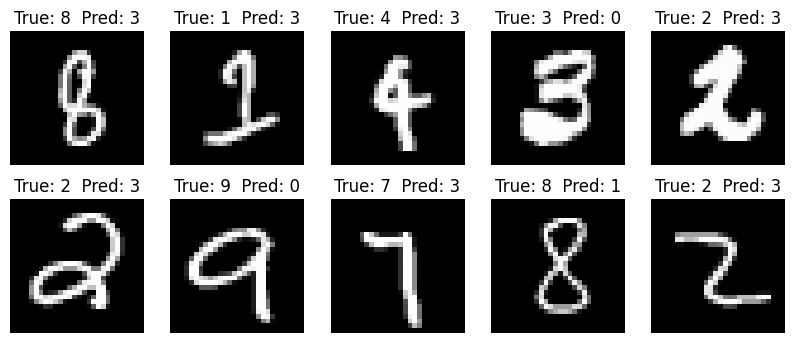

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

model = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=5
)

model.fit(X_train, y_train)

results = model.predict(X_test)
accuracy = model.score(X_test, y_test)


errors = (results != y_test)
X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = results[errors]

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_err[i].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_err[i]}  Pred: {y_pred_err[i]}")
    ax.axis("off")
